# Synonyms detection
    Try to normalise words with different spellings to a single, common spelling to ensure that equivalent tokens receive similar representations

In [1]:
import myfunctions as f
f.today()

'20180206'

In [2]:
import sys
print "system_info: %s"%sys.version
# current working directory
import os
print "path_info: %s"%os.getcwd()  

system_info: 2.7.14 |Anaconda custom (64-bit)| (default, Oct 27 2017, 18:21:12) 
[GCC 7.2.0]
path_info: /home/yueliu/Desktop/workspace_yue/Documentation_201712


In [3]:
file_name = "all_food_vendor__lemma__20180122.p"
df = f.retrive_file(file_name)
print ("Got %d non-drink/dessert food-vendor records" % df.shape[0])
print ("Got %d unique non-drink/dessert food " % 
       df["clean_name"].nunique())

retrived: all_food_vendor__lemma__20180122.p
Got 333572 non-drink/dessert food-vendor records
Got 98238 unique non-drink/dessert food 


In [4]:
df.head(2)

,food_name,vendor_name,locs,clean_name,lemma_name,lemma_name_2
4,Japanese Pickle Roll (6 pcs),Sen of Japan,"[(2017-07-03T17:55:01.668428, deliveroo/food/7...",japanese pickle roll,japanese pickle roll,japanese pickle roll
5,\t HK Kailan with Oyster Sauce\t,Wee Nam Kee Hainanese Chicken Rice - Boon Lay,"[(2018-01-01T04:00:05.703635, deliveroo/food/A...",kailan with oyster sauce,kailan with oyster sauce,kailan with oyster sauce


In [5]:
""" view past synonyms: lists of lists """
def retrive_syn_tokens():
    import os
    import pickle
    prefix = "syn_token"  
    original_path = "/home/yueliu/Desktop/workspace_yue"
    date_list = list(set([f.split("__")[-1].replace(".p", "") 
         for f in os.listdir(original_path) if (f.endswith(".p") and (prefix) in f)]))
    recent_date = sorted(date_list)[-1]
    file_name = os.path.join(original_path,"__".join([prefix, recent_date]) + ".p")
    with open(file_name, 'rb') as pfile:
        retrived = pickle.load(pfile)       
    print ("retrived: %s" % file_name)
    print "number of syn tokens: %d"%len(retrived)
    return retrived

syn_tokens = retrive_syn_tokens()
syn_tokens[0]

retrived: /home/yueliu/Desktop/workspace_yue/syn_token__20170926.p
number of syn tokens: 3764


['po',
 'bao',
 'bau',
 'bun',
 'pao',
 'pau',
 u'pav',
 'paw',
 'poh',
 'pow',
 u'buns',
 u'paws',
 'wrap',
 'bread',
 u'wraps',
 'batter',
 u'breads',
 'man do',
 'breaded',
 u'man dou',
 u'man tao',
 u'man tau',
 'man tou',
 u'man tow',
 'wrapped',
 'battered',
 u'man doing']

# Construct new synonym sets

In [6]:
from gensim.models import Word2Vec
sentences = [l.split() for l in df["lemma_name"].tolist()]
word2vec_filepath = os.path.join(os.getcwd(), 'word2vec_model_all')

# train the model, Commonly, used min_count=20, ,use min_count=1 to find spelling errors
if 1==0:
    # initiate the model and perform the first epoch of training
    food2vec = Word2Vec(sentences, size=100, window=2,
                        min_count=1, sg=1, workers=4)
    food2vec.save(word2vec_filepath)
    # perform another 11 epochs of training
    for i in range(1,12):
        food2vec.train(sentences)
        food2vec.save(word2vec_filepath)
        
# load the finished model from disk
food2vec = Word2Vec.load(word2vec_filepath)
food2vec.init_sims()

print u'{} training epochs so far.'.format(food2vec.train_count)
print u'{:,} terms in the food2vec vocabulary.'.format(len(food2vec.vocab))

12 training epochs so far.
16,239 terms in the food2vec vocabulary.


In [7]:
# build a dictionary of terms and term counts from the food2vec model vocabulary
vocab_freq = {term:voc.count for term, voc in food2vec.vocab.iteritems()}

# build a list of the terms, integer indices,
# and term counts from the food2vec model vocabulary
import pandas as pd
ordered_vocab = [(term, voc.index, voc.count) for term, voc in food2vec.vocab.iteritems()]
# sort by the term counts, so the most common terms appear first
ordered_vocab = sorted(ordered_vocab, key=lambda (term, index, count): -count)
# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)
# create a DataFrame with the food2vec vectors as data, and the terms as row labels
word_vectors = pd.DataFrame(food2vec.syn0norm[term_indices, :],index=ordered_terms)

# select a subset of words considered for pairs
all_words = list(word_vectors.index)
word_subset = [ w for w in all_words if (len(w)>1 and w!='-PRON-')]
print len(word_subset)

16221


## Find misspellings
    Check for tokens with the similar embeddings & similar spellings
Conditions:
> 1. rank: topn = round(16239*0.001,1)
2. similarity: sim_cutoff=np.percentile(sims, 90)
3. levenstein distance or (containment & larger levenstein distance)

DescribeResult(nobs=263705121, minmax=(-0.47539659805241563, 1.0000000000000016), mean=0.38247606905380382, variance=0.036665012092387969, skewness=-0.4478078218206751, kurtosis=0.41555732927058076)


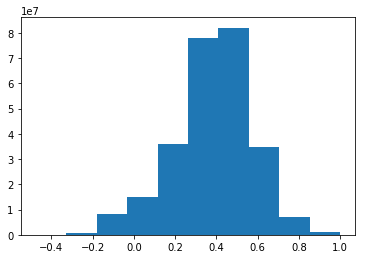

In [8]:
%matplotlib inline
## find pair-wise similarities of all tokens
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
sims = cosine_similarity(word_vectors.values.tolist())

# print description
print stats.describe(sims.flatten())
n, bins, patches = plt.hist(sims.flatten())
plt.show()

In [9]:
df_sims = pd.DataFrame(sims, index=word_vectors.index, columns=word_vectors.index)

In [12]:
# Obtain pairs to measure the levenstein distance
import numpy as np
def potential_pairs(_df_sims=df_sims, _word_subset=word_subset, 
                    sim_cutoff=np.percentile(sims, 90), rank_cutoff=50):
    pair_ranks = {}
    for w in _word_subset: 
        vals = _df_sims[w]
        ranks = vals.rank(ascending=False)
        for w1 in _word_subset:
            v = vals[w1]
            if (w!=w1) & (v > sim_cutoff):
                r = int(ranks[w1])
                if r < rank_cutoff:
                    pair_ranks.update({(w, w1):r})
    print "number of pairs considered: %d"%len(pair_ranks)
    return pair_ranks

In [13]:
%%time
pair_ranks = potential_pairs()

number of pairs considered: 636071
CPU times: user 1h 10min 50s, sys: 23.5 s, total: 1h 11min 13s
Wall time: 1h 10min 41s


In [14]:
# print out some potential pairs 
[(k, pair_ranks[k]) for k in pair_ranks.keys()[:30]]

[((u'rench', u'clifshot'), 17),
 ((u'mezashi', u'amristari'), 12),
 ((u'suicide', u'chickren'), 7),
 ((u'option', u'masama'), 4),
 ((u'bhujia', u'chatpate'), 19),
 ((u'dom', u'burgudy'), 13),
 ((u'licenciado', u'viura'), 32),
 ((u'calon', u'estaphe'), 38),
 ((u'milano', u'bari'), 6),
 ((u'brunello', u'castellani'), 27),
 ((u'cencaru', u'bandeng'), 36),
 ((u'lachna', u'lacha'), 6),
 ((u'stirlion', u'nz'), 30),
 ((u'temptation', u'seitan'), 49),
 ((u'tex', u'jai'), 48),
 ((u'heartshape', u'twiscuit'), 23),
 ((u'pendang', u'nena'), 23),
 ((u'khew', u'wann'), 18),
 ((u'taak', u'krop'), 29),
 ((u'naw', u'moung'), 24),
 ((u'carlsberg', u'crazin'), 30),
 ((u'khasi', u'urundai'), 30),
 ((u'barbazul', u'valdemoreda'), 41),
 ((u'kirmizi', u'kelle'), 25),
 ((u'thing', u'buff'), 14),
 ((u'trufful', u'kanpyo'), 30),
 ((u'vieille', u'motte'), 18),
 ((u'chapa', u'sieben'), 14),
 ((u'ite', u'clipper'), 36),
 ((u'pyramid', u'kichadi'), 27)]

In [15]:
def highly_ranked(token_a, token_b, topn=50, _pair_ranks=pair_ranks):
    try:
        r = _pair_ranks[(token_a, token_b)]
        if r < topn:
            return True
    except:
        try:
            r = _pair_ranks[(token_b, token_a)]
            if r < topn:
                return True
        except:
            return False
# if token_a contains token_b, or the reverse
def string_contain(token_a, token_b):
    if (token_a in token_b) | (token_b in token_a):
        return True
    return False

In [16]:
# Levenstein distance (efficient implementation via numpy), from Wikipedia
def levenshtein(source, target):
    import numpy as np
    if len(source) < len(target):
        return levenshtein(target, source)

    # So now we have len(source) >= len(target).
    if len(target) == 0:
        return len(source)

    # We call tuple() to force strings to be used as sequences
    # ('c', 'a', 't', 's') - numpy uses them as values by default.
    source = np.array(tuple(source))
    target = np.array(tuple(target))

    # We use a dynamic programming algorithm, but with the
    # added optimization that we only need the last two rows
    # of the matrix.
    previous_row = np.arange(target.size + 1)
    for s in source:
        # Insertion (target grows longer than source):
        current_row = previous_row + 1

        # Substitution or matching:
        # Target and source items are aligned, and either
        # are different (cost of 1), or are the same (cost of 0).
        current_row[1:] = np.minimum(
                current_row[1:],
                np.add(previous_row[:-1], target != s))

        # Deletion (target grows shorter than source):
        current_row[1:] = np.minimum(
                current_row[1:],
                current_row[0:-1] + 1)

        previous_row = current_row

    return previous_row[-1]

In [17]:
%%time
""" compute levenstein distances"""
pairs = pair_ranks.keys()
unique_pairs = sorted(list(set([tuple(sorted(p)) for p in pairs])))
dist = [[p[0],p[1],levenshtein(p[0], p[1])]  for p in unique_pairs]
print len(dist)
print dist[0]

513632
[u'aa', u'ahi', 2]
CPU times: user 46.5 s, sys: 208 ms, total: 46.7 s
Wall time: 46.6 s


In [18]:
%%time
""" 
1. rank(token_a, token_b) among the top 0.1% of all tokens
2. levenstein(token_a, token_b) <= 1
OR: levenstein(token_a, token_b) <= 2 & token_a contains token_b
=> get word pairs
=> get word synsets
"""
from copy import copy
max_dist = 1
max_dist2 = 4
topn = round(16239*0.001,1)
result_pairs = []
for d in dist:
    if highly_ranked(d[0], d[1], topn):
        d1 = copy(d)
        if string_contain(d[0], d[1]):
            d1.append("True")
        if d1[2] <= max_dist or (len(d1)>3 and d1[2] <= max_dist2):
            result_pairs.append(d1)

CPU times: user 924 ms, sys: 68 ms, total: 992 ms
Wall time: 933 ms


In [19]:
print max_dist
print len(result_pairs)

1
1446


In [20]:
# group the syntoken pairs into lists of lists
def add_new(pair_lst, vocab_freq):
    from copy import deepcopy
    """ the words in pairs """
    updated = [list(lst) for lst in syn_tokens]
    updated.extend([p[:2] for p in pair_lst])
    # words not in vocab_freq is assigned freq = 0
    vocab_freq.update({token:0 for token 
                       in set([item for sub in updated for item in sub]
                             ).difference(set(vocab_freq.keys()))})
    """ merge pairs to lists, via graph """
    from collections import defaultdict
    def connected_components(lists):
        neighbors = defaultdict(set)
        seen = set()
        for each in lists:
            for item in each:
                neighbors[item].update(each)
        def component(node, neighbors=neighbors, seen=seen, see=seen.add):
            nodes = set([node])
            next_node = nodes.pop
            while nodes:
                node = next_node()
                see(node)
                nodes |= neighbors[node] - seen
                yield node
        for node in neighbors:
            if node not in seen:
                yield sorted(component(node))    
    """ check if new token sets can be merged """
    temp = list(connected_components(updated))
    # higher freq, shorter spelling in front
    def sort_synset(l):
        l_withspace = list(set([v for v in l if " " in v]))
        l_wospace = list(set([v for v in l if " " not in v]))
        combined = sorted(l_withspace ,key=lambda x: (-vocab_freq[x], len(x), x)
                   ) + sorted(l_wospace ,key=lambda x: (-vocab_freq[x], len(x), x))
        return combined
        
    temp = sorted([sort_synset(lst) for lst in temp])
    print "number of syn-token sets change from %d to %d"%(len(syn_tokens), len(temp))    
#     """ print out updated synsets """      
#     lst_check = [l for l in temp if l not in syn_tokens] # in updated,  not in temp
#     print "number of syn-token sets to be checked: %d"%len(lst_check)
#     def look_for_token(ele, lst):
#         index = []
#         for i in range(len(lst)):
#             if ele in lst[i]:
#                 index.append(i)
#         return index
#     for lst in lst_check:        # check merged syntokens
#         result = []
#         for ele in lst:
#             result.extend(look_for_token(ele,syn_tokens))
#         print ""
#         print lst
#         for i in sorted(list(set(result))):
#             print i
#             print syn_tokens[i]
    return temp

In [21]:
# start fresh
syn_tokens = []
syn_tokens = add_new(result_pairs, vocab_freq)

number of syn-token sets change from 0 to 962


In [22]:
print syn_tokens[:3]

[[u'aba', u'abba'], [u'absolut', u'absolute'], [u'adige', u'adigo']]


In [23]:
def save_syn_tokens(syn_tokens):
    import pickle
    file_name = "__".join(["syn_token", f.today()]) + ".p"  
    with open(file_name, 'wb') as pfile:
        pickle.dump(syn_tokens, pfile)
    print "saved: %s"%file_name

In [24]:
# itentify syntoken sets via a token
def find_syntoken_set(s, syn_tokens=syn_tokens):
    for lst in syn_tokens:
        if s in lst:
            print lst

In [25]:
find_syntoken_set("tom", syn_tokens)

[u'tom', u'yum', u'yom']


In [44]:
# update a wrong synset with a correct version
def replace_syntoken_set(lst1, lst2, _syn_tokens, _vocab_freq=vocab_freq):
    temp = [x for x in _syn_tokens if x != lst1] +[lst2]
    # update vocab_freq
    _vocab_freq.update({token:0 for token  in set([item for sub in temp for 
                                                   item in sub]
                             ).difference(set(_vocab_freq.keys()))})
    # higher freq, shorter spelling in front
    temp = sorted([sorted(list(set(lst)) ,key=lambda x: (-_vocab_freq[x], len(x), x))
            for lst in temp])
    print "number of syn-token sets change from %d to %d"%(len(_syn_tokens), len(temp))    
    return temp

In [27]:
syn_tokens = replace_syntoken_set([u'tom', u'yum', u'yom'], [u'yum', u'yom'], 
                                  syn_tokens)

number of syn-token sets change from 962 to 962


In [28]:
find_syntoken_set("yum", syn_tokens)

[u'yum', u'yom']


## Find incorrect spaces
    Check for possible connected tokens (phrases)
Conditions:
> 1. check for words commonly appear together to be phrases (2,3,4-gram)
2. see whether phrases(2,3,4-gram) exist in vocab by removing "_"

In [29]:
from gensim.models import Phrases
unigram_sentences  = [l.split() for l in df["lemma_name"].tolist()]
bigram_model = Phrases(unigram_sentences)
bigram_sentences = []
for unigram_sentence in unigram_sentences:
    bigram_sentences.append(bigram_model[unigram_sentence])

In [30]:
bigram_tokens = set([w for sentence in bigram_sentences for w in sentence])
bigram_tokens = sorted(list(w for w in bigram_tokens if "_" in w))
print "numer of bigram tokens: %d"%len(bigram_tokens)
bigram_tokens[:20]

numer of bigram tokens: 3778


[u'-PRON-_own',
 u'-PRON-_tiao',
 u'-PRON-_would',
 u'aburi_ika',
 u'aburi_maguro',
 u'aburi_mekajiki',
 u'aburi_nama',
 u'acai_superfruit',
 u'adai_avial',
 u'adana_kebab',
 u'adelaide_hill',
 u'age_dashi',
 u'aged_cuttlefish',
 u'aged_tempranillo',
 u'aged_vinegar',
 u'agedashi_tofu',
 u'aglio_oilo',
 u'aglio_olio',
 u'agnello_alla',
 u'agnello_grigliato']

In [31]:
multigram_model = Phrases(bigram_sentences)
multigram_sentences = []
for bigram_sentence in bigram_sentences:
    multigram_sentences.append(multigram_model[bigram_sentence])
multigram_tokens = set([w for sentence in multigram_sentences for w in sentence])
multigram_tokens = sorted(list(w for w in multigram_tokens if len(w.split("_"))>2))
print "numer of multigram tokens: %d"%len(multigram_tokens)
multigram_tokens[:20]

numer of multigram tokens: 1654


[u'-PRON-_tiao_biscuit_rojak',
 u'aburi_ika_sushi',
 u'aburi_mekajiki_sushi',
 u'aburi_nama_hotate_sushi',
 u'adelaide_hill_south_australia',
 u'aglio_olio_peperoncino',
 u'aglio_olio_pepperoncino',
 u'ah_kon_ginger',
 u'ah_ma_mian',
 u'ah_por_ginger',
 u'ai_frutti_di_mare',
 u'ai_quattro_formaggi',
 u'ai_yu_jelly',
 u'air_fly_grass_feed',
 u'airflown_prime_ribeye_steak',
 u'airflown_prime_striploin_steak',
 u'ajwaini_machli_tikka',
 u'aka_ebi_aburi',
 u'aka_ebi_sushi',
 u'al_funghi_porcini']

In [32]:
result=[]
for w in bigram_tokens + multigram_tokens:
    word_trasformed = w.replace("_", "")
    if word_trasformed in vocab_freq.keys():
        result.append(w)
print "number of misspellings identified: %d"%len(result)

number of misspellings identified: 269


In [33]:
result[:20]

[u'age_dashi',
 u'ai_yu',
 u'aka_ebi',
 u'all_aragosta',
 u'aloe_vera',
 u'baba_ganoush',
 u'baby_back',
 u'back_rib',
 u'bai_l',
 u'bara_chirashi',
 u'bean_curd',
 u'bean_sprout',
 u'bee_hoon',
 u'bi_bim',
 u'bi_hun',
 u'bird_nest',
 u'bitter_gourd',
 u'bitter_ground',
 u'black_pepper',
 u'blue_berry']

In [34]:
syn_tokens = add_new([[w.replace("_", ""), w.replace("_", " ")] for w in result]
                     , vocab_freq)

number of syn-token sets change from 962 to 1168


In [40]:
save_syn_tokens(syn_tokens)

saved: syn_token__20180207.p


# Name processing with synonyms

### Some multi-word phrases may be in the same synset as their components
> 1. print out these phrases
2. manually check synsets contraining phrases, split the synsets into different synsets by replacing synset with a partial version and add additional synset if necessary

In [36]:
# print all synset with phrase contain word
check = []
for l in syn_tokens:
    ind = False
    l_withspace = list(set([v for v in l if " " in v]))
    l_wospace = list(set([v for v in l if " " not in v]))
    for p in l_withspace:
        ps = p.split()
        for a in l_wospace:
            if a in ps:
                ind = True
    if ind:
        check.append(l)
print len(check)        

41


In [37]:
check

[[u'age dashi', u'agedashi', u'dashi', u'dashitofu'],
 [u'back rib', u'back', u'backrib', u'backribs'],
 [u'bean curd', u'beancurd', u'curd', u'curb'],
 [u'bee hoon', u'hoon', u'bee', u'beehoon', u'meehoon'],
 [u'bi bim', u'bi', u'bibim', u'bim', u'hebi'],
 [u'chirashi don', u'chirashi', u'shirashi', u'chirashidon'],
 [u'clay pot', u'claypot', u'clay'],
 [u'cous cous', u'cous', u'couscous'],
 [u'criss cut', u'criss', u'cross', u'cris', u'crisscut'],
 [u'dim sum', u'dim', u'dimsum'],
 [u'fai dang', u'fai', u'faidang'],
 [u'fu rong', u'fu yong', u'yong', u'fuyong', u'furong'],
 [u'fugu mirin', u'mirin', u'fugumirin'],
 [u'hara bhara',
  u'bara',
  u'hara',
  u'bhara',
  u'harasu',
  u'harabhara',
  u'harasume',
  u'bharaa'],
 [u'hor fun', u'fun', u'horfun'],
 [u'ikan bili', u'bili', u'ikambili', u'ikanbili'],
 [u'jing du', u'jing', u'jingdu'],
 [u'kai lan', u'lan', u'kailan'],
 [u'kang kong', u'kang', u'kangkong', u'kangkung', u'kan'],
 [u'kra tiem', u'kra', u'kratiem', u'krai', u'kratia

In [38]:
checked = [[u'age dashi', u'agedashi',  u'dashitofu'],
 [u'back rib',  u'backrib', u'backribs'],
 [u'bean curd', u'beancurd', ],
 [u'bee hoon',  u'beehoon', u'meehoon'],
 [u'bi bim', u'bibim'],
 [u'chirashi don',  u'chirashidon'],
 [u'clay pot', u'claypot'],
 [u'cous cous', u'couscous'],
 [u'criss cut',  u'crisscut'],
 [u'dim sum',  u'dimsum'],
 [u'fai dang',u'faidang'],
 [u'fu rong', u'fu yong',  u'fuyong', u'furong'],
 [u'fugu mirin', u'fugumirin'],
 [u'hara bhara', u'harabhara',],
 [u'hor fun', u'horfun'],
 [u'ikan bili', u'ikambili', u'ikanbili'],
 [u'jing du', u'jingdu'],
 [u'kai lan',  u'kailan'],
 [u'kang kong', u'kangkong', u'kangkung'],
 [u'kra tiem',  u'kratiem', u'kratiam', u'takkrai'],
 [u'lily bulb', u'lilybulb'],
 [u'mc laren',  u'clare', u'mclaren', u'mclren'],
 [u'mentai yaki', u'mentaiyaki'],
 [u'nor mai', u'normai'],
 [u'phu nim', u'phunim'],
 [u'rogan josh', u'roganjosh',],
 [u'sea bass', u'seabass', ],
 [u'sea bream', u'seabream'],
 [u'shao x', u'shaox'],
 [u'shark fin',  u'sharkfin'],
 [u'shio yaki', u'shioyaki',  u'shiokyaki', u'shioyakki'],
 [u'shoe string', u'shoestr', u'shoestring'],
 [u'side winder', u'sidewinder',],
 [u'skuttle butt', u'skuttlebutt'],
 [u'soon dubu',  u'soondubu'],
 [u'tar tar', u'tartar', u'tartare', u'tartart', u'tatar'],
 [u'tenshin han', u'tenshinhan',],
 [u'ting zai',  u'tingzai'],
 [u'tori soboro',  u'torisoboro'],
 [u'yu sheng',  u'yusheng'],
 [u'zha jiang', u'zhajiang']]

In [39]:
print len(check)==len(checked)

True


In [48]:
for i in range(len(check)):
    syn_tokens = replace_syntoken_set(check[i], checked[i], syn_tokens)
    syn_tokens = add_new([], vocab_freq)

number of syn-token sets change from 1208 to 1209
number of syn-token sets change from 1209 to 1168
number of syn-token sets change from 1168 to 1168
number of syn-token sets change from 1168 to 1168
number of syn-token sets change from 1168 to 1168
number of syn-token sets change from 1168 to 1168
number of syn-token sets change from 1168 to 1168
number of syn-token sets change from 1168 to 1168
number of syn-token sets change from 1168 to 1168
number of syn-token sets change from 1168 to 1168
number of syn-token sets change from 1168 to 1168
number of syn-token sets change from 1168 to 1168
number of syn-token sets change from 1168 to 1168
number of syn-token sets change from 1168 to 1168
number of syn-token sets change from 1168 to 1168
number of syn-token sets change from 1168 to 1168
number of syn-token sets change from 1168 to 1168
number of syn-token sets change from 1168 to 1168
number of syn-token sets change from 1168 to 1168
number of syn-token sets change from 1168 to 1168


In [50]:
increased = [
    [u'curd', u'curb'],   
    [u'bi',u'bim'],  
    [u'criss', u'cross', u'cris'],
    [u'kang', u'kan'],
    [u'zhen jiang', u'zhenjiang'],
    [u'chirashi', u'shirashi'],
    [u'rogan', u'roghan', u'rugan', u'rogam', u'rojan'],
    [u'kra', u'krai'],
    [u'bara',  u'bhara',  u'bharaa'],   
]
syn_tokens = add_new(increased, vocab_freq)

number of syn-token sets change from 1168 to 1177


In [52]:
save_syn_tokens(syn_tokens)

saved: syn_token__20180207.p


# Substitute food names with predefined synonym tokens

In [51]:
print ("Got %d unique non-drink/dessert food " % 
       df["lemma_name"].nunique())

Got 95613 unique non-drink/dessert food 


In [53]:
def retrive_syn_tokens():
    import os
    import pickle
    prefix = "syn_token"    
    date_list = list(set([f.split("__")[-1].replace(".p", "") 
         for f in os.listdir(os.getcwd()) if (f.endswith(".p") and (prefix) in f)]))
    recent_date = sorted(date_list)[-1]

    file_name = "__".join([prefix, recent_date]) + ".p"
    with open(file_name, 'rb') as pfile:
        retrived = pickle.load(pfile)       
    print ("retrived: %s" % file_name)
    print "number of syn tokens: %d"%len(retrived)
    return retrived
syn_token = retrive_syn_tokens()

retrived: syn_token__20180207.p
number of syn tokens: 1177


In [54]:
def rev_dict(x):
    """ return the first element in lst as value """
    return dict((x[i],x[0]) for i in range(1, len(x)))
def merge_dicts(d_lst):
    """ shallow copy and merge into new dict"""
    result = {}
    for dictionary in d_lst:
        result.update(dictionary)
    return result

def replace_token(s):
    """ partial string matching """
    s = " " + s + " "
    s = s.replace(" ", "  ")
    for key in keys:       
        s = s.replace(" " + key.replace(" ", "  ") + " ", " " + rev_lookup[key] + " ")
    import re
    s = re.sub(' +',' ', s.strip()) # multiple spaces    
    return s    

rev_lookup = merge_dicts([rev_dict(x) for x in syn_tokens])  
keys = sorted(list(set(rev_lookup.keys())),key=lambda x: -len(x))

In [56]:
%%time
df["standard_name"] = df["lemma_name"].apply(replace_token)

CPU times: user 10min 53s, sys: 5.45 s, total: 10min 58s
Wall time: 10min 52s


In [57]:
file_name = "__".join(["all_food_vendor","standard", f.today()]) + ".p"
f.save_file(df, file_name)

saved: all_food_vendor__standard__20180207.p


In [58]:
df.head(2)

,food_name,vendor_name,locs,clean_name,lemma_name,lemma_name_2,standard_name
4,Japanese Pickle Roll (6 pcs),Sen of Japan,"[(2017-07-03T17:55:01.668428, deliveroo/food/7...",japanese pickle roll,japanese pickle roll,japanese pickle roll,japanese pickle roll
5,\t HK Kailan with Oyster Sauce\t,Wee Nam Kee Hainanese Chicken Rice - Boon Lay,"[(2018-01-01T04:00:05.703635, deliveroo/food/A...",kailan with oyster sauce,kailan with oyster sauce,kailan with oyster sauce,kai lan with oyster sauce
